Library Import

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load image function to Load the images



In [3]:
# cat_img = []
# dog_img = []
# panda_img = []

def load_images(folder,label):
  images = []
  labels = []
  for filename in os.listdir(folder):
    path = os.path.join(folder,filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
      img = cv2.resize(img,(32,32))
      img = img.flatten()
      images.append(img)
      labels.append(label)
  return images,labels

Load and Covert to numpy array

In [4]:
base_path = '/content/drive/MyDrive/CVPR/Mid/animal_dataset'
cat_img,cat_labels = load_images(os.path.join(base_path,'cat'),0)
dog_img,dog_labels = load_images(os.path.join(base_path,'dog'),1)
panda_img,panda_labels = load_images(os.path.join(base_path,'panda'),2)

X = np.array(cat_img+dog_img+panda_img)
y = np.array(cat_labels+dog_labels+panda_labels)


Check the Shape and Size

In [5]:
print("Number of cat images:", len(cat_img))
print("Number of dog images:", len(dog_img))
print("Number of panda images:", len(panda_img))

Number of cat images: 100
Number of dog images: 100
Number of panda images: 100


In [6]:
print(X.shape) # 32 * 32 = 1024
print(y.shape)

(300, 1024)
(300,)


Visualize if images loaded or not

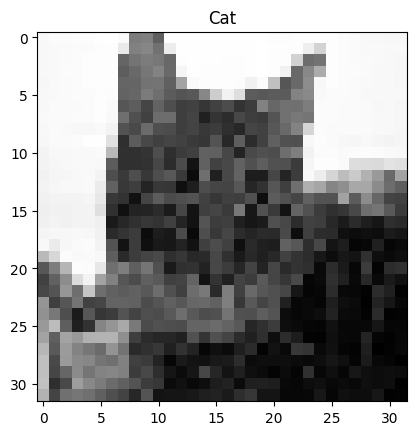

In [7]:
import matplotlib.pyplot as plt

plt.imshow(cat_img[2].reshape(32, 32), cmap='gray')
plt.title("Cat")
plt.show()

Suffling the images

In [8]:
indices = np.arange(len(X))
# print(indices)
np.random.shuffle(indices)
# print(indices)
# print(X)
X = X[indices]
# print(X)
y = y[indices]



Euclidean & Manhattan distence measurement function to implement KNN

In [9]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def predict(X_train, y_train, x_test, k, distance_metric="euclidean"):
    distances = []
    for i in range(len(X_train)):
      if distance_metric == "euclidean":
        distance = euclidean_distance(X_train[i], x_test)
      elif distance_metric == "manhattan":
        distance = manhattan_distance(X_train[i], x_test)
      distances.append((distance, y_train[i]))
    # sort the list of tuples by distance
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    return max(set(k_labels), key=k_labels.count)

5 Fold Cross validation and KNN implementation

In [13]:
import matplotlib.pyplot as plt
import random

def create_folds(X, y, num_folds=5):
    data = list(zip(X, y))
    random.shuffle(data)
    fold_size = len(data) // num_folds
    folds = []
    for i in range(num_folds):
        start = i * fold_size
        end = (i+1)*fold_size if i < num_folds - 1 else len(data)
        fold = data[start:end]
        X_fold, y_fold = zip(*fold)
        folds.append((np.array(X_fold), np.array(y_fold)))
    return folds

k_values = list(range(1, 21))  # k=1 to 20
folds = create_folds(X, y, num_folds=5)

# ---------------- Euclidean ----------------

euclidean_fold_accuracies = [[] for _ in range(5)]
euclidean_average_accuracies = []

for k in k_values:
    fold_acc = []
    for i in range(5):
        X_valid, y_valid = folds[i]
        X_train = np.concatenate([folds[j][0] for j in range(5) if j != i])
        y_train = np.concatenate([folds[j][1] for j in range(5) if j != i])

        correct = 0
        for idx in range(len(X_valid)):
            pred = predict(X_train, y_train, X_valid[idx], k, distance_metric="euclidean")
            if pred == y_valid[idx]:
                correct += 1
        acc = correct / len(X_valid)
        euclidean_fold_accuracies[i].append(acc)
        fold_acc.append(acc)

    avg_acc = np.mean(fold_acc)
    euclidean_average_accuracies.append(avg_acc)

for fold_num in range(5):
    print(f"\nFold {fold_num + 1} (Euclidean):")
    for idx, k in enumerate(k_values):
        acc = euclidean_fold_accuracies[fold_num][idx] * 100
        print(f"  Accuracy for k={k}: {acc:.2f}%")
    print(f"   Average Accuracy: {euclidean_average_accuracies[idx]*100:.2f}%")



# ---------------- Manhattan ----------------

manhattan_fold_accuracies = [[] for _ in range(5)]
manhattan_average_accuracies = []

for k in k_values:
    fold_acc = []
    for i in range(5):
        X_valid, y_valid = folds[i]
        X_train = np.concatenate([folds[j][0] for j in range(5) if j != i])
        y_train = np.concatenate([folds[j][1] for j in range(5) if j != i])

        correct = 0
        for idx in range(len(X_valid)):
            pred = predict(X_train, y_train, X_valid[idx], k, distance_metric="manhattan")
            if pred == y_valid[idx]:
                correct += 1
        acc = correct / len(X_valid)
        manhattan_fold_accuracies[i].append(acc)
        fold_acc.append(acc)

    avg_acc = np.mean(fold_acc)
    manhattan_average_accuracies.append(avg_acc)

for fold_num in range(5):
    print(f"\nFold {fold_num + 1} (Manhattan):")
    for idx, k in enumerate(k_values):
        acc = manhattan_fold_accuracies[fold_num][idx] * 100
        print(f"  Accuracy for k={k}: {acc:.2f}%")
    print(f"   Average Accuracy: {manhattan_average_accuracies[idx]*100:.2f}%")


Fold 1 (Euclidean):
  Accuracy for k=1: 36.67%
  Accuracy for k=2: 31.67%
  Accuracy for k=3: 38.33%
  Accuracy for k=4: 45.00%
  Accuracy for k=5: 46.67%
  Accuracy for k=6: 46.67%
  Accuracy for k=7: 45.00%
  Accuracy for k=8: 55.00%
  Accuracy for k=9: 50.00%
  Accuracy for k=10: 50.00%
  Accuracy for k=11: 45.00%
  Accuracy for k=12: 43.33%
  Accuracy for k=13: 40.00%
  Accuracy for k=14: 41.67%
  Accuracy for k=15: 45.00%
  Accuracy for k=16: 40.00%
  Accuracy for k=17: 41.67%
  Accuracy for k=18: 45.00%
  Accuracy for k=19: 45.00%
  Accuracy for k=20: 46.67%
   Average Accuracy: 44.33%

Fold 2 (Euclidean):
  Accuracy for k=1: 46.67%
  Accuracy for k=2: 51.67%
  Accuracy for k=3: 48.33%
  Accuracy for k=4: 53.33%
  Accuracy for k=5: 45.00%
  Accuracy for k=6: 43.33%
  Accuracy for k=7: 50.00%
  Accuracy for k=8: 56.67%
  Accuracy for k=9: 48.33%
  Accuracy for k=10: 43.33%
  Accuracy for k=11: 48.33%
  Accuracy for k=12: 45.00%
  Accuracy for k=13: 43.33%
  Accuracy for k=14: 43.

 KNN cross‑validation accuracy curve using Euclidean distance

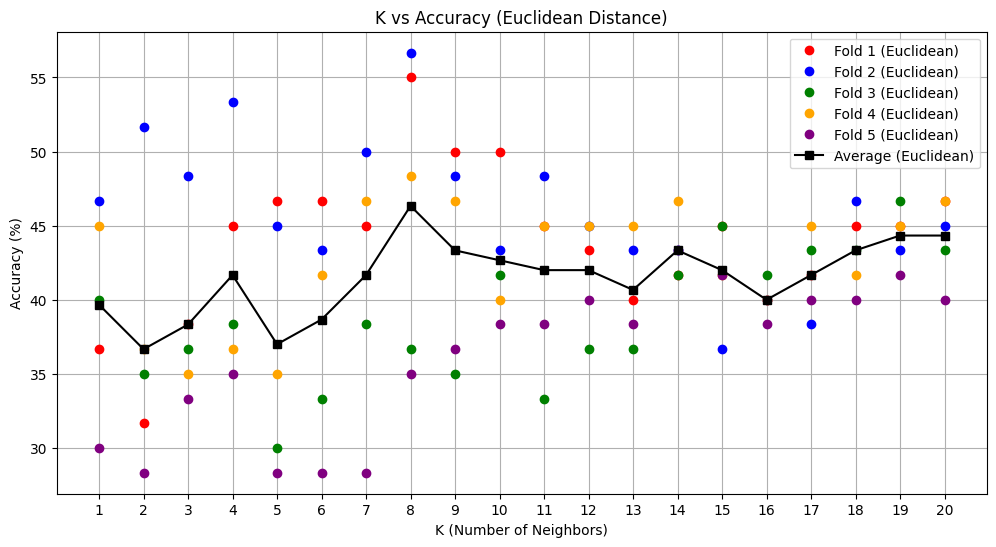

In [16]:
colors = ['red','blue','green','orange','purple']
plt.figure(figsize = (12,6))

# Plot individual fold points (Euclidean)
for i in range(5):
    plt.plot(k_values, [a*100 for a in euclidean_fold_accuracies[i]],
             linestyle='', marker='o', label=f'Fold {i+1} (Euclidean)', color=colors[i])

# Plot average line (Euclidean)
plt.plot(k_values, [a*100 for a in euclidean_average_accuracies],
         linestyle='-', marker='s', color='black', label='Average (Euclidean)')

plt.title("K vs Accuracy (Euclidean Distance)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.xticks(k_values)
plt.show()

 KNN cross‑validation accuracy curve using Manhattan distance

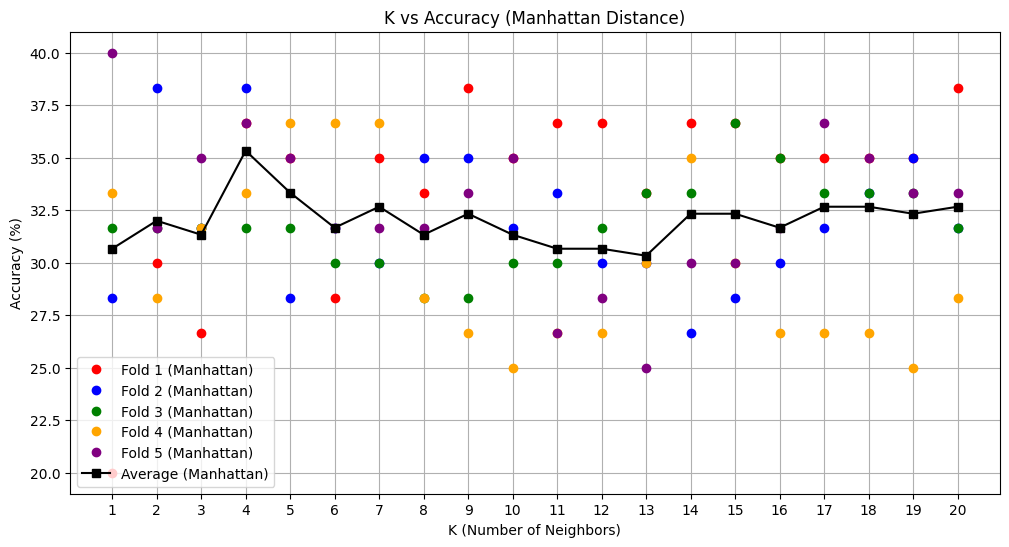

In [18]:
colors = ['red','blue','green','orange','purple']
plt.figure(figsize = (12,6))

# Plot individual fold points (Manhattan)
for i in range(5):
    plt.plot(k_values, [a*100 for a in manhattan_fold_accuracies[i]],
             linestyle='', marker='o', label=f'Fold {i+1} (Manhattan)', color=colors[i])

# Plot average line (Manhattan)
plt.plot(k_values, [a*100 for a in manhattan_average_accuracies],
         linestyle='-', marker='s', color='black', label='Average (Manhattan)')

plt.title("K vs Accuracy (Manhattan Distance)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.xticks(k_values)
plt.show()

comparison of KNN classification accuracy across different values of k using Euclidean vs Manhattan distance metrics.


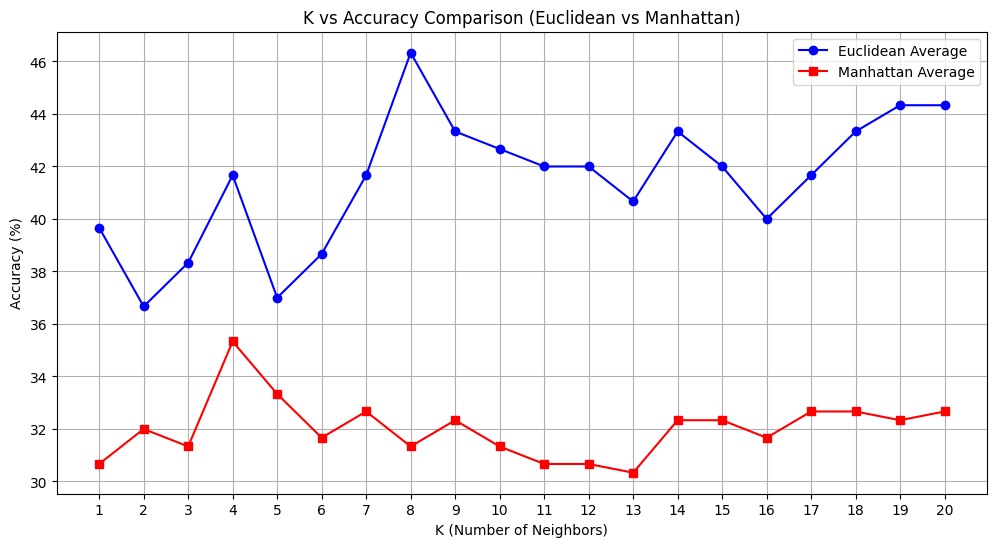

In [19]:
plt.figure(figsize=(12,6))

# Plot Euclidean average line
plt.plot(k_values, [a*100 for a in euclidean_average_accuracies],
         linestyle='-', marker='o', color='blue', label='Euclidean Average')

# Plot Manhattan average line
plt.plot(k_values, [a*100 for a in manhattan_average_accuracies],
         linestyle='-', marker='s', color='red', label='Manhattan Average')

plt.title("K vs Accuracy Comparison (Euclidean vs Manhattan)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.xticks(k_values)
plt.show()

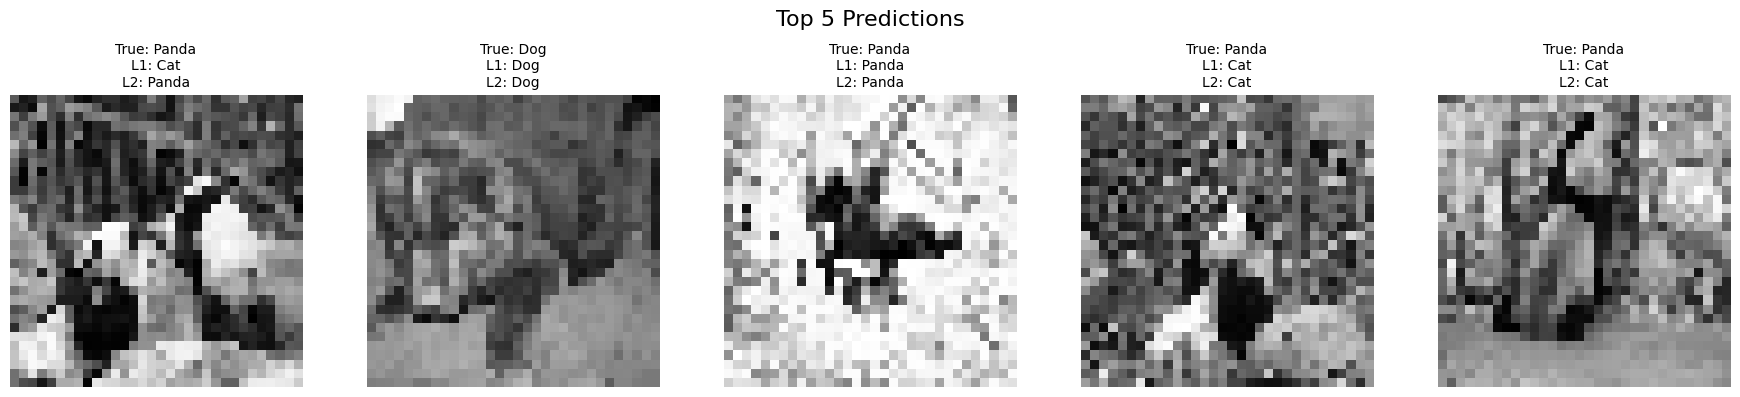

In [25]:
import random

# Define class names
classes = ["Cat", "Dog", "Panda"]

sample_ids = random.sample(range(len(X)), 5)

plt.figure(figsize=(18,4))

for i, idx in enumerate(sample_ids):
    img = X[idx]
    true_label = y[idx]

    pred_L1 = predict(X, y, img, k=3, distance_metric="manhattan")
    pred_L2 = predict(X, y, img, k=3, distance_metric="euclidean")

    plt.subplot(1,5,i+1)
    plt.imshow(img.reshape(32,32), cmap="gray")
    plt.axis("off")
    plt.title(f"True: {classes[true_label]}\nL1: {classes[pred_L1]}\nL2: {classes[pred_L2]}",
              fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.suptitle("Top 5 Predictions", fontsize=16)
plt.show()